<a href="https://colab.research.google.com/github/tbeucler/2024_UNIL_Geoinformatique/blob/main/Colab_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on model performance and complexity, this Jupyter notebook reproduces Pareto-optimal model hierarchies for three atmospheric physics application cases:

1. Cloud cover parameterization
2. Shortwave radiative transfer
3. Tropical precipitation modeling

In [38]:
# Please enter the path to the data below
path_data = '/content/'
#path_data = '/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2024_Pareto_Distillation_Data'

# Imports, Data Loading, and Shared Functions

## Imports

In [39]:
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap

import numpy as np

import os

import pandas as pd

import pickle as pkl

In [40]:
# Parameters for plotting
fz = 40 # Fontsize
lw = 2 # Linewidth
siz = 100 # Marker size

# Set parameters for plotting
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['lines.linewidth'] = lw
plt.rc('font', size=fz)

In [41]:
# Colors for plotting

# 1) Shades of blue from Figure 1
colors_fig1 = {
    "pale_blue": [222, 238, 248],
    "light_blue": [190, 223, 239],
    "medium_blue": [131, 197, 217],
    "deep_blue": [53, 144, 173],
    "dark_blue": [32, 88, 106]
}

# Convert each color component by dividing by 255
normalized_colors = {
    key: [value / 255 for value in values]
    for key, values in colors_fig1.items()
}
colors_fig1 = normalized_colors

# 2) Shades of pinks for NNs in Figure 2
# Define the colors for the colormap with significantly increased contrast
colors = [
    (1.0, 0.08, 0.58),  # DeepPink
    (0.9, 0.4, 0.7),   # Distinct intermediate color
    (0.7, 0.0, 0.7),   # Another distinct intermediate color
    (0.58, 0.0, 0.83)  # DarkViolet
]

# Create the colormap
pink_cmap = LinearSegmentedColormap.from_list('DeepPinkDarkViolet', colors, N=5)

# 3) Shades of green for the distilled models in Figure 2
green_cmap = plt.get_cmap('YlGn',5)
# Generate some data
data = np.linspace(0, 1, 100).reshape(10, 10)



## Data loading

In [42]:
# Cloud cover data
cc = json.load(open(f'{path_data}/cloud_cover.json'))

# Shortwave radiative transfer data
rt = pd.read_csv(f'{path_data}/SW_RT.csv', delimiter=',')

# Tropical precipitation data
with open(os.path.join(path_data, 'Tropical_Precipitation.pkl'), 'rb') as f:
    tmp = pkl.load(f)
# Create a new data structure to store the model data
tp = {}
# Iterate through the items in the provided data
for item in tmp.items():
    model_name, characteristics = item
    for k, v in characteristics.items():
        # Initialize the sub-dictionary for key 'k' if it doesn't exist
        tp.setdefault(k, {})
        # Initialize the sub-dictionary for model_name if it doesn't exist
        tp[k].setdefault(model_name, {})
        # Add the value to the sub-dictionary
        tp[k][model_name] = v

## Shared functions

In [43]:
#@title Double click to see the Pareto functions' code

def is_pareto_efficient_simple(costs):

    """
    Identify the Pareto-efficient points for a given set of costs.

    Parameters:
    costs (np.array): A 2D NumPy array where each row represents an individual point
                      in terms of its cost dimensions. For instance, each row could
                      represent a different configuration's cost as [cost1, cost2].

    Returns:
    np.array: A boolean array where True indicates that the corresponding point in
              'costs' is Pareto efficient.

    Description:
    This function iterates over each point and determines whether it is dominated
    by any other point. A point is considered Pareto efficient if no other point
    exists that is better in all cost dimensions. In this context, "better" is
    defined as being lower for each cost dimension since we are minimizing.

    The function uses a boolean array, `is_efficient`, to keep track of which
    points are currently considered Pareto efficient. Initially, all points are
    assumed to be Pareto efficient.

    For each point:
    1. If the point is still considered potentially Pareto efficient (`is_efficient[i]` is True),
       it checks against all other points that are also still marked as efficient.
    2. It updates the `is_efficient` array by setting it to False for any point
       that is dominated by the current point. A point `j` is dominated by point `i`
       if all its cost dimensions are greater than or equal to those of point `i`
       and at least one dimension is strictly greater.
    3. It ensures the current point's efficiency status remains True regardless of the
       comparison outcome by resetting `is_efficient[i]` to True after the comparison.

    The loop ensures that every point is compared with all others, and after processing,
    the `is_efficient` array flags only those points that are not dominated by any other,
    indicating the Pareto front.
    """

    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient

def extract_pareto_data(dataframe, key_substrings,
                        original_dict=None, new_point_1_mse_scores=700, new_point_2_parameters=5.4,
                        key_x='Complexity/Number of parameters', key_y='MSE scores on validation set'):
    # Set default for original_dict if not provided
    if original_dict is None:
        original_dict = cc[key_x].keys()

    # Filter keys by substrings
    filtered_keys = {
        key for key in original_dict
        if any(sub in key for sub in key_substrings)
    }

    # Extract parameters and MSE scores for the filtered models
    parameters = [np.log10(dataframe[key_x][k]) for k in filtered_keys]
    mse_scores = [dataframe[key_y][k] for k in filtered_keys]

    # Determine Pareto optimal points
    pareto_points = is_pareto_efficient_simple(np.column_stack((parameters, mse_scores)))

    # Extract current Pareto points
    pareto_parameters = np.array(parameters)[pareto_points]
    pareto_mse_scores = np.array(mse_scores)[pareto_points]

    # Sort the initial Pareto points based on parameters
    sorted_indices = np.argsort(pareto_parameters)
    pareto_parameters = pareto_parameters[sorted_indices]
    pareto_mse_scores = pareto_mse_scores[sorted_indices]

    # Define new points
    new_point_1_parameters = min(parameters)  # Minimum of all parameters
    new_point_2_mse_scores = min(mse_scores)  # Minimum of all scores

    # Insert new point 1 at the beginning
    pareto_parameters = np.insert(pareto_parameters, 0, new_point_1_parameters)
    pareto_mse_scores = np.insert(pareto_mse_scores, 0, new_point_1_mse_scores)

    # Append new point 2 at the end
    pareto_parameters = np.append(pareto_parameters, new_point_2_parameters)
    pareto_mse_scores = np.append(pareto_mse_scores, new_point_2_mse_scores)

    return parameters, mse_scores, pareto_parameters, pareto_mse_scores, filtered_keys

# Cloud Cover Parameterization

## Step 1

Step 1 includes the polynomial models as well as the Sundqvist & Wang baselines.

In [51]:
# Step 1: Extracting Pareto data for polynomial models and Sundqvist & Wang baselines

# Call the 'extract_pareto_data' function to determine Pareto optimal points
# 'cc' contains the cloud cover data
# 'key_substrings' lists substrings to filter relevant models
parameters, mse_scores, pareto_parameters, pareto_mse_scores, filtered_keys = \
    extract_pareto_data(cc, key_substrings = [
        'lin_cl_area',  # Linear models
        'deg_12',       # Degree 1 & 2 polynomial models
        'grid_search',  # Grid search results for baseline models
        'sq',           # Sundqvist baseline model
        'deg_2',        # Degree 2 polynomial models
        'deg_3'         # Degree 3 polynomial models
    ])

# Loop through each filtered key to print out the model's number of parameters and MSE
for k in filtered_keys:
    p = cc['Complexity/Number of parameters'][k]  # Number of parameters for model 'k'
    mse = cc['MSE scores on validation set'][k]   # MSE for model 'k'
    print(f"{k}, Number of parameters={p}, MSE={mse}")  # Print model info

pol_deg_2_cl_area_14, Number of parameters=15, MSE=245.97
pol_deg_2_cl_area_9, Number of parameters=10, MSE=268.76
pol_deg_3_cl_area_3, Number of parameters=4, MSE=450.4
pol_deg_2_cl_area_7, Number of parameters=8, MSE=289.98
deg_2_no_reg_3_no_var_4, Number of parameters=11, MSE=225.21
pol_deg_2_cl_area_12, Number of parameters=13, MSE=252.44
lin_cl_area_11, Number of parameters=12, MSE=402.73
deg_3_no_reg_3_no_var_3, Number of parameters=9, MSE=255.45
lin_cl_area_12, Number of parameters=13, MSE=400.15
wang_grid_search, Number of parameters=2, MSE=336.007
lin_cl_area_15, Number of parameters=16, MSE=397.17
deg_2_no_reg_4_no_var_9, Number of parameters=31, MSE=174.9
pol_deg_2_cl_area_8, Number of parameters=9, MSE=279.74
lin_cl_area_6, Number of parameters=7, MSE=430.1
pol_deg_2_cl_area_21, Number of parameters=22, MSE=222.95
deg_3_no_reg_3_no_var_1, Number of parameters=5, MSE=458.96
pol_deg_2_cl_area_4, Number of parameters=5, MSE=430.54
deg_3_no_reg_4_no_var_4, Number of parameters=

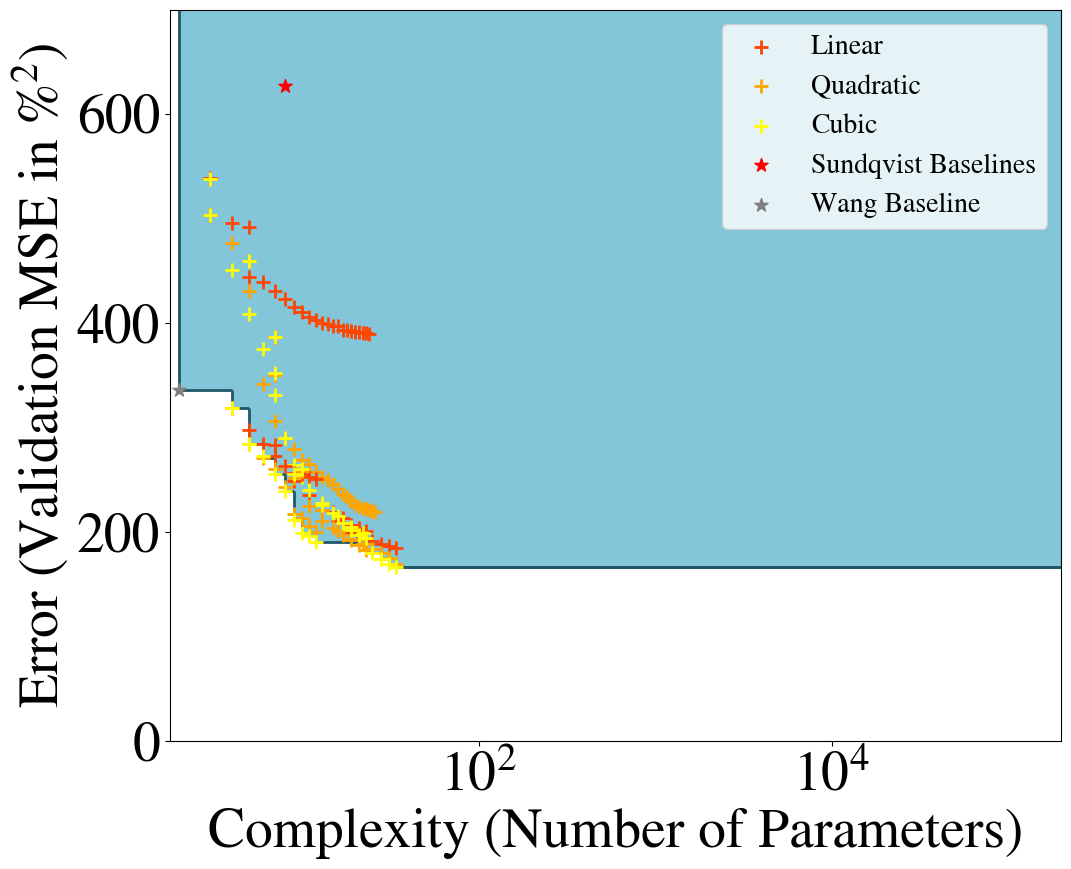

In [52]:
# Plot setup
fig, ax = plt.subplots(figsize=(11.5, 9.5))  # Combined figure and subplot creation

# Color the area above the Pareto front without introducing vertical lines
for i in range(len(pareto_parameters) - 1):
    ax.fill_betweenx([pareto_mse_scores[i], max(mse_scores)],
                     pareto_parameters[i], pareto_parameters[i + 1],
                     color=colors_fig1['medium_blue'])
# Fill the rightmost and leftmost areas
ax.fill_betweenx([min(mse_scores), max(mse_scores)], pareto_parameters[-1], max(parameters),
                 color=colors_fig1['medium_blue'])
ax.fill_betweenx([pareto_mse_scores[0], max(mse_scores)], min(parameters), pareto_parameters[0],
                 color=colors_fig1['medium_blue'])

# Draw the Pareto front with vertical and horizontal lines
for i in range(len(pareto_parameters)):
    if i > 0:
        ax.vlines(x=pareto_parameters[i], ymin=pareto_mse_scores[i-1], ymax=pareto_mse_scores[i],
                  color=colors_fig1['dark_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores[i], xmin=pareto_parameters[i],
              xmax=pareto_parameters[i+1] if i+1 < len(pareto_parameters) else max(parameters),
              color=colors_fig1['dark_blue'], linewidth=2)

# Plot all points except NNs/equations
for k in cc['Complexity/Number of parameters'].keys():
    col, m, cap, skip = '#FF000000', '+', '', 0  # Default values
    if 'lin_cl_area' in k or 'deg_1' in k:
        col, cap = 'orangered', 'Linear' if 'lin_cl_area' in k else ''
    elif 'sq_grid_search' in k:
        col, m, cap = 'red', '*', 'Sundqvist Baselines'
    elif 'wang_grid_search' in k:
        col, m, cap = 'gray', '*', 'Wang Baseline'
    elif 'pol_deg_2' in k or 'deg_2' in k:
        col, cap = 'orange', 'Quadratic' if 'pol_deg_2' in k else ''
    elif 'pol_deg_3' in k or 'deg_3' in k:
        col, cap = 'yellow', 'Cubic' if 'pol_deg_3' in k else ''
    elif 'cell_NN' in k:
        col, cap = pink_cmap(1), 'Neural Network (NN) Baseline'
        skip = True
    elif 'seq_feat_sel_NN' in k:
        col, cap = pink_cmap(5), 'NN with Sequentially Selected Features'
        skip = True
    elif 'pysr' in k:
        col, cap = green_cmap(5), 'Discovered PySR equation'
        skip = True
    elif 'gpgomea' in k:
        col, cap = green_cmap(2), 'Discovered GP-GOMEA equation'
        skip = True
    elif 'NN' in k:
        col, cap = pink_cmap(2), 'Non-Local NN'
        skip = True
    if not skip:
        ax.scatter(np.log10(cc['Complexity/Number of parameters'][k]),
                   cc['MSE scores on validation set'][k],
                   s=siz, color=col, zorder=2, marker=m, label=cap)

# Set limits
ax.set_xlim((0.25, 5.3))
ax.set_ylim((0, 699))

# Improve the plot
plt.xlabel('Complexity (Number of Parameters)')
plt.ylabel('Error (Validation MSE in $\%^2$)')

# Eliminate all redundant legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Ensure the color of 'Linear' is 'orangered'
for handle, label in zip(handles, labels):
    if label == 'Linear':
        handle.set_color('orangered')

# Create new legend entries
new_labels = ['Linear', 'Quadratic', 'Cubic', 'Sundqvist Baselines', 'Wang Baseline']
new_handles = [by_label[label] for label in new_labels]
plt.legend(new_handles, new_labels, fontsize=fz/2)

# Use scientific notation for x-ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'$10^{{{int(x)}}}$'))

plt.show()

## Step 2

In [53]:
# Step 2: Extracting Pareto data including polynomial models, Sundqvist & Wang baselines, and NN models

# Call the 'extract_pareto_data' function to determine Pareto optimal points
# 'cc' contains the cloud cover data
# 'key_substrings' lists substrings to filter relevant models including NN models
parameters2, mse_scores2, pareto_parameters2, pareto_mse_scores2, filtered_keys2 = \
    extract_pareto_data(cc, key_substrings = [
        'lin_cl_area',  # Linear models
        'deg_12',       # Degree 1 & 2 polynomial models
        'grid_search',  # Grid search results for baseline models
        'sq',           # Sundqvist baseline model
        'deg_2',        # Degree 2 polynomial models
        'deg_3',        # Degree 3 polynomial models
        'NN'            # Neural Networks
    ])

# Loop through each filtered key to print out the model's number of parameters and MSE
for k in filtered_keys2:
    p = cc['Complexity/Number of parameters'][k]  # Number of parameters for model 'k'
    mse = cc['MSE scores on validation set'][k]   # MSE for model 'k'
    print(f"{k}, Number of parameters={p}, MSE={mse}")  # Print model info

pol_deg_2_cl_area_14, Number of parameters=15, MSE=245.97
pol_deg_2_cl_area_9, Number of parameters=10, MSE=268.76
pol_deg_3_cl_area_3, Number of parameters=4, MSE=450.4
seq_feat_sel_NN_6, Number of parameters=673, MSE=55.7913
pol_deg_2_cl_area_7, Number of parameters=8, MSE=289.98
deg_2_no_reg_3_no_var_4, Number of parameters=11, MSE=225.21
pol_deg_2_cl_area_12, Number of parameters=13, MSE=252.44
lin_cl_area_11, Number of parameters=12, MSE=402.73
deg_3_no_reg_3_no_var_3, Number of parameters=9, MSE=255.45
lin_cl_area_12, Number of parameters=13, MSE=400.15
wang_grid_search, Number of parameters=2, MSE=336.007
lin_cl_area_15, Number of parameters=16, MSE=397.17
deg_2_no_reg_4_no_var_9, Number of parameters=31, MSE=174.9
pol_deg_2_cl_area_8, Number of parameters=9, MSE=279.74
lin_cl_area_6, Number of parameters=7, MSE=430.1
pol_deg_2_cl_area_21, Number of parameters=22, MSE=222.95
seq_feat_sel_NN_7, Number of parameters=2529, MSE=46.6461
seq_feat_sel_NN_10, Number of parameters=9345, 

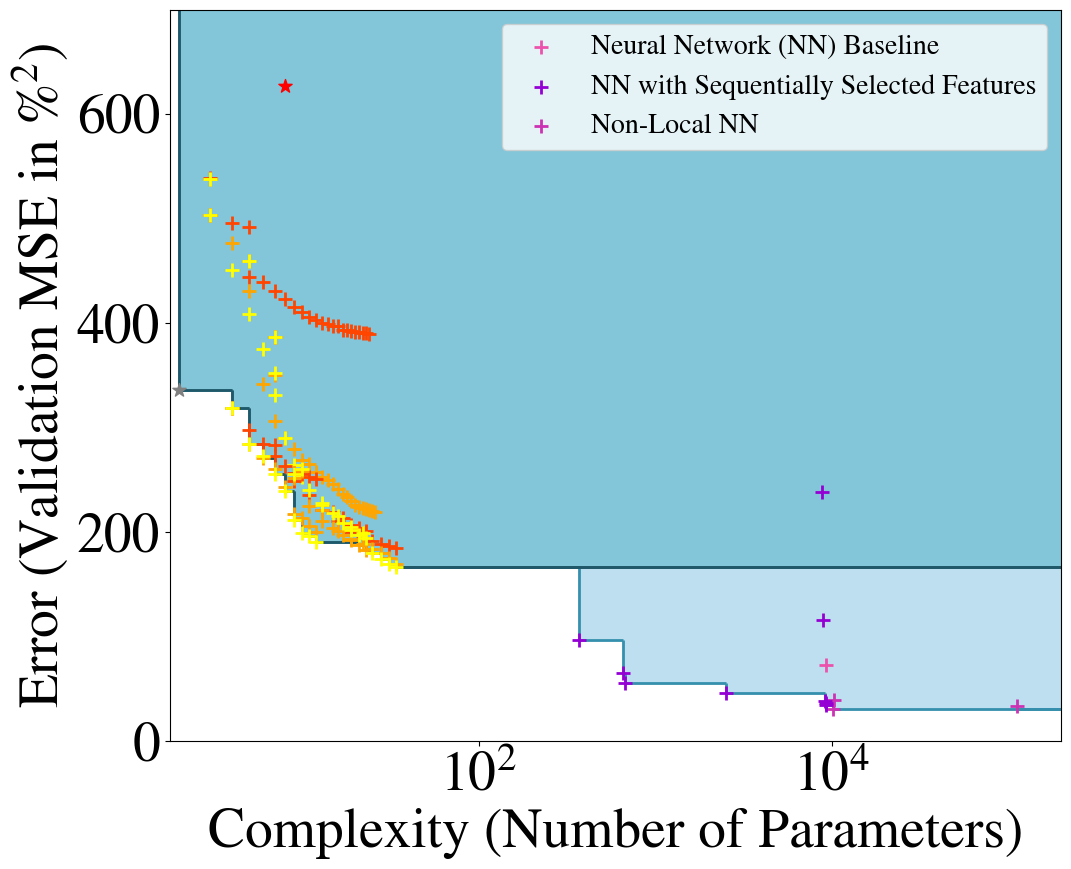

In [54]:
# Step 2: Plotting Pareto data including polynomial models, Sundqvist & Wang baselines, and NN models

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

# Plot setup
fig, ax = plt.subplots(figsize=(11.5, 9.5))  # Combined figure and subplot creation

# Color the area above the Pareto front for Step 2
for i in range(len(pareto_parameters2) - 1):
    ax.fill_betweenx([pareto_mse_scores2[i], max(mse_scores2)],
                     pareto_parameters2[i], pareto_parameters2[i + 1],
                     color=colors_fig1['light_blue'])
# Fill the rightmost and leftmost areas for Step 2
ax.fill_betweenx([min(mse_scores2), max(mse_scores2)], pareto_parameters2[-1], max(parameters2),
                 color=colors_fig1['light_blue'])
ax.fill_betweenx([pareto_mse_scores2[0], max(mse_scores2)], min(parameters2), pareto_parameters2[0],
                 color=colors_fig1['light_blue'])

# Draw the Pareto front with vertical and horizontal lines for Step 2
for i in range(len(pareto_parameters2)):
    if i > 0:
        ax.vlines(x=pareto_parameters2[i], ymin=pareto_mse_scores2[i-1], ymax=pareto_mse_scores2[i],
                  color=colors_fig1['deep_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores2[i], xmin=pareto_parameters2[i],
              xmax=pareto_parameters2[i+1] if i+1 < len(pareto_parameters2) else max(parameters2),
              color=colors_fig1['deep_blue'], linewidth=2)

# Color the area above the Pareto front for Step 1
for i in range(len(pareto_parameters) - 1):
    ax.fill_betweenx([pareto_mse_scores[i], max(mse_scores)],
                     pareto_parameters[i], pareto_parameters[i + 1],
                     color=colors_fig1['medium_blue'])
# Fill the rightmost and leftmost areas for Step 1
ax.fill_betweenx([min(mse_scores), max(mse_scores)], pareto_parameters[-1], max(parameters),
                 color=colors_fig1['medium_blue'])
ax.fill_betweenx([pareto_mse_scores[0], max(mse_scores)], min(parameters), pareto_parameters[0],
                 color=colors_fig1['medium_blue'])

# Draw the Pareto front with vertical and horizontal lines for Step 1
for i in range(len(pareto_parameters)):
    if i > 0:
        ax.vlines(x=pareto_parameters[i], ymin=pareto_mse_scores[i-1], ymax=pareto_mse_scores[i],
                  color=colors_fig1['dark_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores[i], xmin=pareto_parameters[i],
              xmax=pareto_parameters[i+1] if i+1 < len(pareto_parameters) else max(parameters),
              color=colors_fig1['dark_blue'], linewidth=2)

# Plot all points except NNs/equations
for k in cc['Complexity/Number of parameters'].keys():
    col, m, cap, skip = '#FF000000', '+', '', 0  # Default values
    if 'lin_cl_area' in k or 'deg_1' in k:
        col, cap = 'orangered', 'Linear' if 'lin_cl_area' in k else ''
    elif 'sq_grid_search' in k:
        col, m, cap = 'red', '*', 'Sundqvist Baselines'
    elif 'wang_grid_search' in k:
        col, m, cap = 'gray', '*', 'Wang Baseline'
    elif 'pol_deg_2' in k or 'deg_2' in k:
        col, cap = 'orange', 'Quadratic' if 'pol_deg_2' in k else ''
    elif 'pol_deg_3' in k or 'deg_3' in k:
        col, cap = 'yellow', 'Cubic' if 'pol_deg_3' in k else ''
    elif 'cell_NN' in k:
        col, cap = pink_cmap(1), 'Neural Network (NN) Baseline'
    elif 'seq_feat_sel_NN' in k:
        col, cap = pink_cmap(5), 'NN with Sequentially Selected Features'
    elif 'pysr' in k:
        col, cap = green_cmap(5), 'Discovered PySR equation'
        skip = True
    elif 'gpgomea' in k:
        col, cap = green_cmap(2), 'Discovered GP-GOMEA equation'
        skip = True
    elif 'NN' in k:
        col, cap = pink_cmap(2), 'Non-Local NN'
    if not skip:
        ax.scatter(np.log10(cc['Complexity/Number of parameters'][k]),
                   cc['MSE scores on validation set'][k],
                   s=siz, color=col, zorder=2, marker=m, label=cap)

# Set limits
ax.set_xlim((0.25, 5.3))
ax.set_ylim((0, 699))

# Improve the plot
plt.xlabel('Complexity (Number of Parameters)')
plt.ylabel('Error (Validation MSE in $\%^2$)')
plt.legend(loc='upper right')

# Eliminate all redondant legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),fontsize=fz/2)
# Change the order of the last three labels
# to "Sundqvist Baseline", "Neural Network (NN) Baseline", and "NN with Sequentially Selected Features"
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
new_labels = ['Neural Network (NN) Baseline', 'NN with Sequentially Selected Features', 'Non-Local NN']
new_handles = [by_label[label] for label in new_labels]
# Change the color of the 'NN with Sequentially Selected Features' label to pink_cmap(5)
new_handles[1].set_color(pink_cmap(5))
plt.legend(new_handles, new_labels,fontsize=fz/2)

# Use scientific notation for x-ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'$10^{{{int(x)}}}$'))

plt.show()


## Step 3

In [55]:
# Step 3: Extracting Pareto data including polynomial models, Sundqvist & Wang baselines, NN models, and discovered equations

# Call the 'extract_pareto_data' function to determine Pareto optimal points
# 'cc' contains the cloud cover data
# 'key_substrings' lists substrings to filter relevant models including NN models and discovered equations
parameters3, mse_scores3, pareto_parameters3, pareto_mse_scores3, filtered_keys3 = \
    extract_pareto_data(cc, key_substrings = [
        'lin_cl_area',  # Linear models
        'deg_12',       # Degree 1 & 2 polynomial models
        'grid_search',  # Grid search results for baseline models
        'sq',           # Sundqvist baseline model
        'deg_2',        # Degree 2 polynomial models
        'deg_3',        # Degree 3 polynomial models
        'NN',           # Neural Networks
        'pysr',         # Discovered PySR equations
        'gpgomea'       # Discovered GP-GOMEA equations
    ])

# Loop through each filtered key to print out the model's number of parameters and MSE
for k in filtered_keys3:
    p = cc['Complexity/Number of parameters'][k]  # Number of parameters for model 'k'
    mse = cc['MSE scores on validation set'][k]   # MSE for model 'k'
    print(f"{k}, Number of parameters={p}, MSE={mse}")  # Print model info


pol_deg_2_cl_area_14, Number of parameters=15, MSE=245.97
pol_deg_2_cl_area_9, Number of parameters=10, MSE=268.76
pol_deg_3_cl_area_3, Number of parameters=4, MSE=450.4
seq_feat_sel_NN_6, Number of parameters=673, MSE=55.7913
pol_deg_2_cl_area_7, Number of parameters=8, MSE=289.98
deg_2_no_reg_3_no_var_4, Number of parameters=11, MSE=225.21
pol_deg_2_cl_area_12, Number of parameters=13, MSE=252.44
lin_cl_area_11, Number of parameters=12, MSE=402.73
deg_3_no_reg_3_no_var_3, Number of parameters=9, MSE=255.45
pysr_EQ3, Number of parameters=12, MSE=106.52269626553506
gpgomea Equation 1, Number of parameters=13, MSE=121.88511471084269
lin_cl_area_12, Number of parameters=13, MSE=400.15
wang_grid_search, Number of parameters=2, MSE=336.007
lin_cl_area_15, Number of parameters=16, MSE=397.17
deg_2_no_reg_4_no_var_9, Number of parameters=31, MSE=174.9
pol_deg_2_cl_area_8, Number of parameters=9, MSE=279.74
lin_cl_area_6, Number of parameters=7, MSE=430.1
pol_deg_2_cl_area_21, Number of param

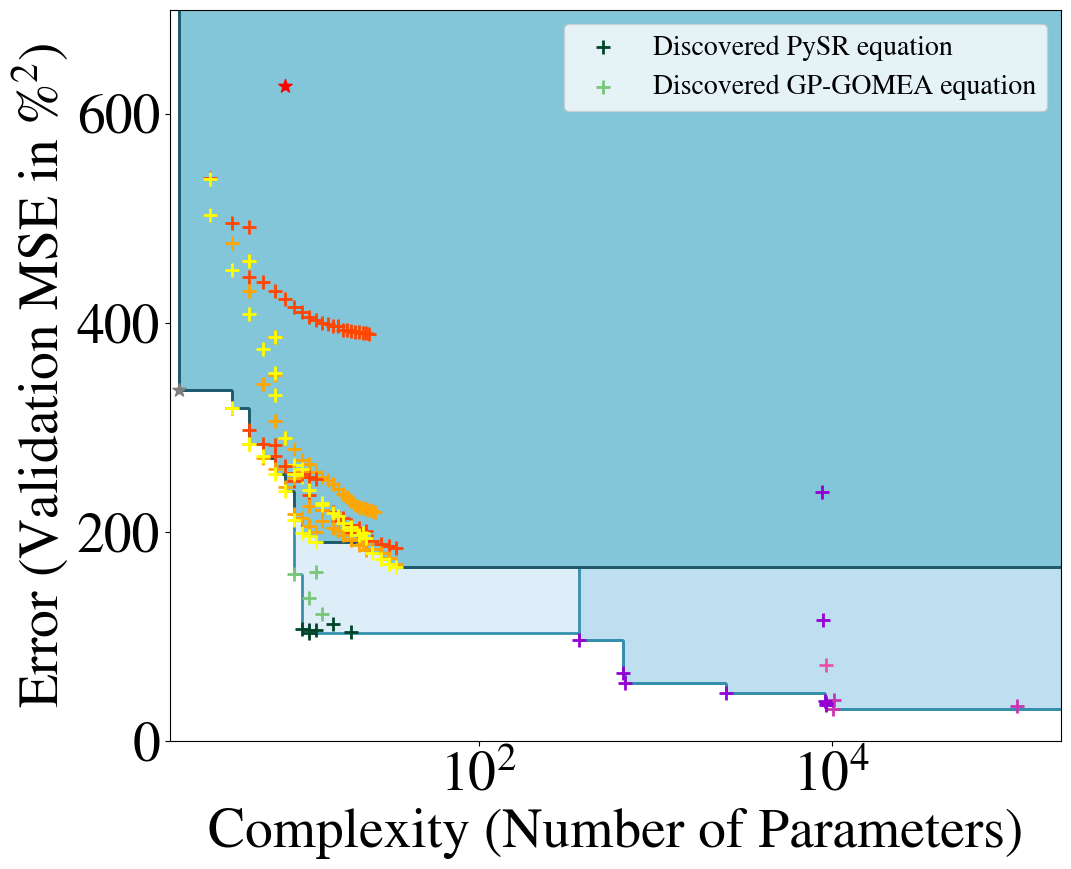

In [56]:
# Step 3: Plotting Pareto data including polynomial models, Sundqvist & Wang baselines, NN models, and discovered equations

# Plot setup
fig, ax = plt.subplots(figsize=(11.5, 9.5))  # Combined figure and subplot creation

# Color the area above the Pareto front (Step 3)
for i in range(len(pareto_parameters3) - 1):
    ax.fill_betweenx([pareto_mse_scores3[i], max(mse_scores3)],
                     pareto_parameters3[i], pareto_parameters3[i + 1],
                     color=colors_fig1['pale_blue'])
# Fill the rightmost and leftmost areas (Step 3)
ax.fill_betweenx([min(mse_scores3), max(mse_scores3)], pareto_parameters3[-1], max(parameters3),
                 color=colors_fig1['pale_blue'])
ax.fill_betweenx([pareto_mse_scores3[0], max(mse_scores3)], min(parameters3), pareto_parameters3[0],
                 color=colors_fig1['pale_blue'])

# Draw the Pareto front with vertical and horizontal lines (Step 3)
for i in range(len(pareto_parameters3)):
    if i > 0:
        ax.vlines(x=pareto_parameters3[i], ymin=pareto_mse_scores3[i-1], ymax=pareto_mse_scores3[i],
                  color=colors_fig1['deep_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores3[i], xmin=pareto_parameters3[i],
              xmax=pareto_parameters3[i+1] if i+1 < len(pareto_parameters3) else max(parameters3),
              color=colors_fig1['deep_blue'], linewidth=2)

# Color the area above the Pareto front (Step 2)
for i in range(len(pareto_parameters2) - 1):
    ax.fill_betweenx([pareto_mse_scores2[i], max(mse_scores2)],
                     pareto_parameters2[i], pareto_parameters2[i + 1],
                     color=colors_fig1['light_blue'])
# Fill the rightmost and leftmost areas (Step 2)
ax.fill_betweenx([min(mse_scores2), max(mse_scores2)], pareto_parameters2[-1], max(parameters2),
                 color=colors_fig1['light_blue'])
ax.fill_betweenx([pareto_mse_scores2[0], max(mse_scores2)], min(parameters2), pareto_parameters2[0],
                 color=colors_fig1['light_blue'])

# Draw the Pareto front with vertical and horizontal lines (Step 2)
for i in range(len(pareto_parameters2)):
    if i > 0:
        ax.vlines(x=pareto_parameters2[i], ymin=pareto_mse_scores2[i-1], ymax=pareto_mse_scores2[i],
                  color=colors_fig1['deep_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores2[i], xmin=pareto_parameters2[i],
              xmax=pareto_parameters2[i+1] if i+1 < len(pareto_parameters2) else max(parameters2),
              color=colors_fig1['deep_blue'], linewidth=2)

# Color the area above the Pareto front (Step 1)
for i in range(len(pareto_parameters) - 1):
    ax.fill_betweenx([pareto_mse_scores[i], max(mse_scores)],
                     pareto_parameters[i], pareto_parameters[i + 1],
                     color=colors_fig1['medium_blue'])
# Fill the rightmost and leftmost areas (Step 1)
ax.fill_betweenx([min(mse_scores), max(mse_scores)], pareto_parameters[-1], max(parameters),
                 color=colors_fig1['medium_blue'])
ax.fill_betweenx([pareto_mse_scores[0], max(mse_scores)], min(parameters), pareto_parameters[0],
                 color=colors_fig1['medium_blue'])

# Draw the Pareto front with vertical and horizontal lines (Step 1)
for i in range(len(pareto_parameters)):
    if i > 0:
        ax.vlines(x=pareto_parameters[i], ymin=pareto_mse_scores[i-1], ymax=pareto_mse_scores[i],
                  color=colors_fig1['dark_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores[i], xmin=pareto_parameters[i],
              xmax=pareto_parameters[i+1] if i+1 < len(pareto_parameters) else max(parameters),
              color=colors_fig1['dark_blue'], linewidth=2)

# Plot all points except NNs/equations
for k in cc['Complexity/Number of parameters'].keys():
    col, m, cap, skip = '#FF000000', '+', '', False  # Default values
    if 'lin_cl_area' in k or 'deg_1' in k:
        col, cap = 'orangered', 'Linear' if 'lin_cl_area' in k else ''
    elif 'sq_grid_search' in k:
        col, m, cap = 'red', '*', 'Sundqvist Baselines'
    elif 'wang_grid_search' in k:
        col, m, cap = 'gray', '*', 'Wang Baseline'
    elif 'pol_deg_2' in k or 'deg_2' in k:
        col, cap = 'orange', 'Quadratic' if 'pol_deg_2' in k else ''
    elif 'pol_deg_3' in k or 'deg_3' in k:
        col, cap = 'yellow', 'Cubic' if 'pol_deg_3' in k else ''
    elif 'cell_NN' in k:
        col, cap = pink_cmap(1), 'Neural Network (NN) Baseline'
    elif 'seq_feat_sel_NN' in k:
        col, cap = pink_cmap(5), 'NN with Sequentially Selected Features'
    elif 'pysr' in k:
        col, cap = green_cmap(5), 'Discovered PySR equation'
    elif 'gpgomea' in k:
        col, cap = green_cmap(2), 'Discovered GP-GOMEA equation'
    elif 'NN' in k:
        col, cap = pink_cmap(2), 'Non-Local NN'
    if not skip:
        ax.scatter(np.log10(cc['Complexity/Number of parameters'][k]),
                   cc['MSE scores on validation set'][k],
                   s=siz, color=col, zorder=2, marker=m, label=cap)

# Set limits
ax.set_xlim((0.25, 5.3))
ax.set_ylim((0, 699))

# Improve the plot
plt.xlabel('Complexity (Number of Parameters)')
plt.ylabel('Error (Validation MSE in $\%^2$)')
plt.legend(loc='upper right')

# Eliminate all redundant legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Only keep the labels containing "equation"
new_labels = [label for label in labels if 'equation' in label]
new_handles = [by_label[label] for label in new_labels]

# Ensure the 'Discovered GP-GOMEA equation' uses the 'green_cmap(2)' color
# and the 'Discovered PySR equation' uses the 'green_cmap(5)' color
for handle, label in zip(new_handles, new_labels):
    if label == 'Discovered GP-GOMEA equation':
        handle.set_color(green_cmap(2))
    elif label == 'Discovered PySR equation':
        handle.set_color(green_cmap(5))

# Eliminate redundant labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
new_labels = ['Discovered PySR equation', 'Discovered GP-GOMEA equation']
new_handles = [by_label[label] for label in new_labels]

plt.legend(new_handles, new_labels, fontsize=fz/2)

# Use scientific notation for x-ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'$10^{{{int(x)}}}$'))

plt.show()


# Shortwave Radiative Transfer

In [72]:
# Choose the regime to base the Pareto hierarchy on
regime = _
#regime = ' overall_heating_rate_mse_k2_day02' # Entire test set
#regime = ' simple_heating_rate_mse_k2_day02' # "Clear-sky" regime
#regime = ' complex_heating_rate_mse_k2_day02' # "Multi-cloud" regime

## Step 1

In [73]:
# Define the key substrings for filtering relevant models
key_substrings = ['linear', 'cnn', 'dense']


# From each column of the dataframe 'df', build a dictionary that uses the column 'model_hyperparams' as keys
# and the column's values as values. The dictionary is stored in another dictionary that uses the column name as key.

# Initialize the dictionary
data_dict = {}

# Iterate over the columns of the dataframe
for col in rt.columns:
    # Initialize the dictionary for the current column
    data_dict[col] = {}
    # Iterate over the rows
    for i in range(len(rt)):
        # Get the model hyperparameters as the key
        key = rt['model_hyperparams'][i]
        # Get the value of the current column for the given row
        value = rt[col][i]
        # Store the value in the dictionary
        data_dict[col][key] = value

# Extract Pareto data using the defined key substrings and additional parameters
parameters, mse_scores, pareto_parameters, pareto_mse_scores, filtered_keys = \
    extract_pareto_data(data_dict, key_substrings,
                        original_dict=rt['model_hyperparams'].unique(),
                        new_point_1_mse_scores=40, new_point_2_parameters=8,
                        key_x=' num_trainable_params', key_y=regime)


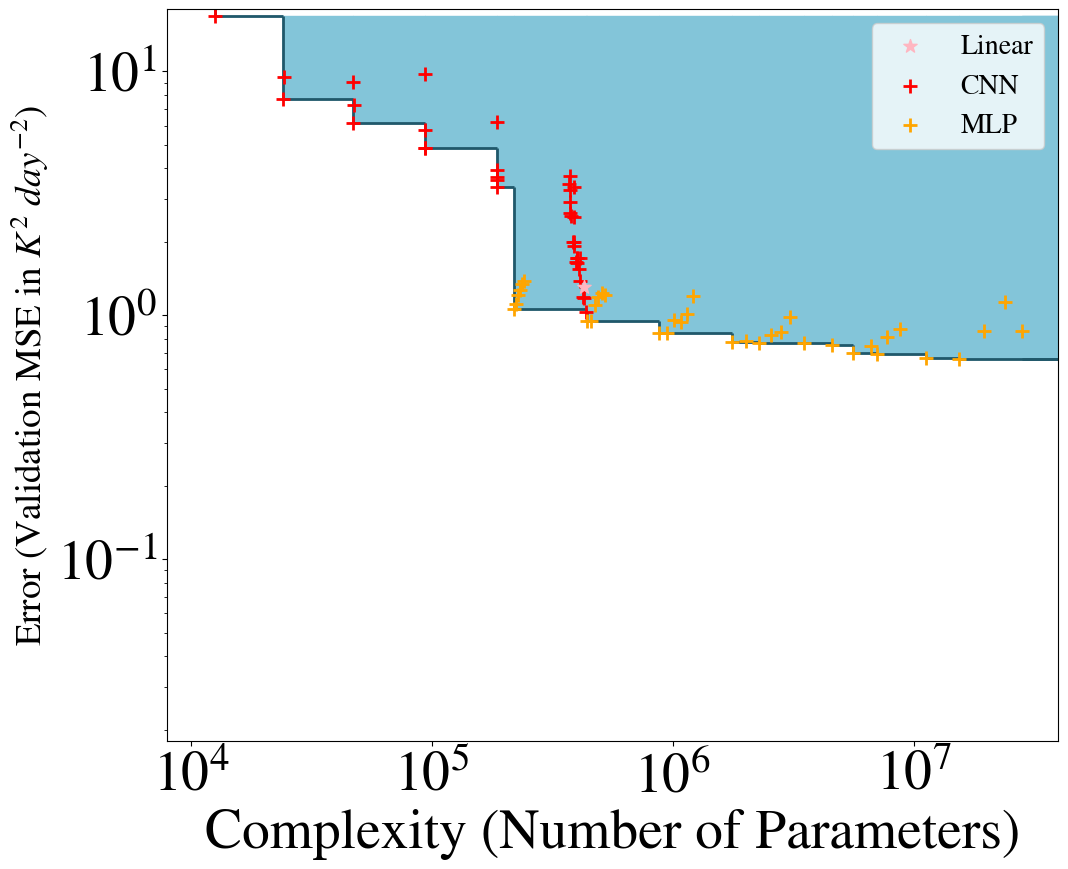

In [74]:
# Plot setup
fig, ax = plt.subplots(figsize=(11.5, 9.5))  # Combined figure and subplot creation

# Color the area above the Pareto front without introducing vertical lines
for i in range(len(pareto_parameters) - 1):
    ax.fill_betweenx([pareto_mse_scores[i], max(mse_scores)],
                     pareto_parameters[i], pareto_parameters[i + 1],
                     color=colors_fig1['medium_blue'])
# Fill the rightmost and leftmost areas
ax.fill_betweenx([min(mse_scores), max(mse_scores)], pareto_parameters[-1], max(parameters),
                 color=colors_fig1['medium_blue'])
ax.fill_betweenx([pareto_mse_scores[0], max(mse_scores)], min(parameters), pareto_parameters[0],
                 color=colors_fig1['medium_blue'])

# Draw the Pareto front with vertical and horizontal lines
for i in range(len(pareto_parameters)):
    if i > 0:
        ax.vlines(x=pareto_parameters[i], ymin=pareto_mse_scores[i-1], ymax=pareto_mse_scores[i],
                  color=colors_fig1['dark_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores[i], xmin=pareto_parameters[i],
              xmax=pareto_parameters[i+1] if i+1 < len(pareto_parameters) else max(parameters),
              color=colors_fig1['dark_blue'], linewidth=2)

for k in filtered_keys:
    skip = False
    if 'linear' in k:
        col, m, cap = 'lightpink', '*', 'Linear'
    elif 'cnn' in k or 'sq_bfgs_regimes' in k:
        col, m, cap = 'red', '+', 'CNN'
    elif 'dense' in k:
        col, m, cap = 'orange', '+', 'MLP'
    elif 'u_net_plusplus' in k:
        col, m, cap = pink_cmap(5), '+', 'U-Net++'
    elif 'u_net' in k:
        col, m, cap = pink_cmap(1), '+', 'U-Net'
    elif 'peter' in k:
        col, m, cap = green_cmap(2), '+', 'Bi-Directional RNN'
    else:
        print('k=', k)
        col, m, cap, skip = 'gray', '+', '', True

    if not skip:
        ax.scatter(np.log10(data_dict[' num_trainable_params'][k]),
                   data_dict[regime][k],
                   s=siz, color=col, zorder=2, marker=m, label=cap)

# Set limits
ax.set_xlim((3.9, 7.6))
ax.set_ylim((0.018, 18))
# Make y-axis log scale
ax.set_yscale('log')

# Improve the plot
plt.xlabel('Complexity (Number of Parameters)')
plt.ylabel('Error (Validation MSE in $K^2\ day^{-2}$)', fontsize=2*fz/3)

# Eliminate redundant legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Keep only specific entries in the legend and use 'cap' as label
filtered_labels = ['Linear', 'CNN', 'MLP']
filtered_handles = [by_label[label] for label in filtered_labels if label in by_label]

plt.legend(filtered_handles, filtered_labels, fontsize=fz/2, loc='upper right')

# Use scientific notation for x-ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'$10^{{{int(x)}}}$'))

plt.show()

## Step 2

In [75]:
# Define the key substrings for filtering relevant models
key_substrings = ['linear', 'cnn', 'dense', 'u_net_plusplus', 'u_net']

# From each column of the dataframe 'rt', build a dictionary that uses the column 'model_hyperparams' as keys
# and the column's values as values. The dictionary is stored in another dictionary that uses the column name as key.

# Initialize the dictionary
data_dict = {}

# Iterate over the columns of the dataframe
for col in rt.columns:
    # Initialize the dictionary for the current column
    data_dict[col] = {}
    # Iterate over the rows
    for i in range(len(rt)):
        # Get the model hyperparameters as the key
        key = rt['model_hyperparams'][i]
        # Get the value of the current column for the given row
        value = rt[col][i]
        # Store the value in the dictionary
        data_dict[col][key] = value

# Extract Pareto data using the defined key substrings and additional parameters
parameters2, mse_scores2, pareto_parameters2, pareto_mse_scores2, filtered_keys2 = \
    extract_pareto_data(data_dict, key_substrings,
                        original_dict=rt['model_hyperparams'].unique(),
                        new_point_1_mse_scores=40, new_point_2_parameters=8,
                        key_x=' num_trainable_params', key_y=regime)


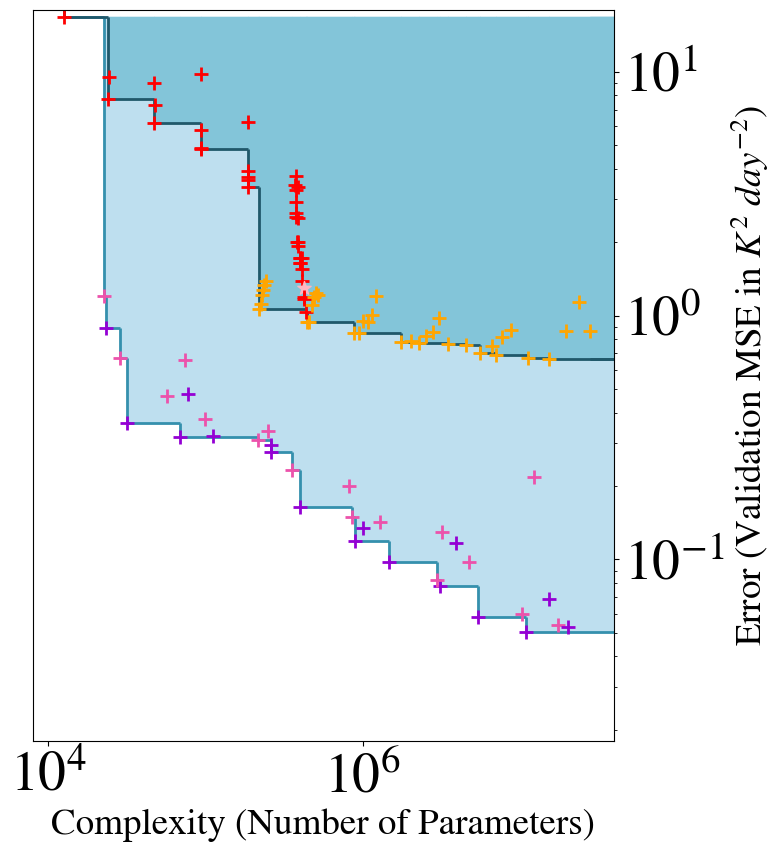

In [76]:
# Plot setup
fig, ax = plt.subplots(figsize=(7.5, 9.5))  # Combined figure and subplot creation

# Color the area above the Pareto front for Step 2
for i in range(len(pareto_parameters2) - 1):
    ax.fill_betweenx([pareto_mse_scores2[i], max(mse_scores2)],
                     pareto_parameters2[i], pareto_parameters2[i + 1],
                     color=colors_fig1['light_blue'])
# Fill the rightmost and leftmost areas for Step 2
ax.fill_betweenx([min(mse_scores2), max(mse_scores2)], pareto_parameters2[-1], max(parameters2),
                 color=colors_fig1['light_blue'])
ax.fill_betweenx([pareto_mse_scores2[0], max(mse_scores2)], min(parameters2), pareto_parameters2[0],
                 color=colors_fig1['light_blue'])

# Draw the Pareto front with vertical and horizontal lines for Step 2
for i in range(len(pareto_parameters2)):
    if i > 0:
        ax.vlines(x=pareto_parameters2[i], ymin=pareto_mse_scores2[i-1], ymax=pareto_mse_scores2[i],
                  color=colors_fig1['deep_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores2[i], xmin=pareto_parameters2[i],
              xmax=pareto_parameters2[i+1] if i+1 < len(pareto_parameters2) else max(parameters2),
              color=colors_fig1['deep_blue'], linewidth=2)

# Color the area above the Pareto front for Step 1
for i in range(len(pareto_parameters) - 1):
    ax.fill_betweenx([pareto_mse_scores[i], max(mse_scores)],
                     pareto_parameters[i], pareto_parameters[i + 1],
                     color=colors_fig1['medium_blue'])
# Fill the rightmost and leftmost areas for Step 1
ax.fill_betweenx([min(mse_scores), max(mse_scores)], pareto_parameters[-1], max(parameters),
                 color=colors_fig1['medium_blue'])
ax.fill_betweenx([pareto_mse_scores[0], max(mse_scores)], min(parameters), pareto_parameters[0],
                 color=colors_fig1['medium_blue'])

# Draw the Pareto front with vertical and horizontal lines for Step 1
for i in range(len(pareto_parameters)):
    if i > 0:
        ax.vlines(x=pareto_parameters[i], ymin=pareto_mse_scores[i-1], ymax=pareto_mse_scores[i],
                  color=colors_fig1['dark_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores[i], xmin=pareto_parameters[i],
              xmax=pareto_parameters[i+1] if i+1 < len(pareto_parameters) else max(parameters),
              color=colors_fig1['dark_blue'], linewidth=2)

# Plot all points except NNs/equations
for k in filtered_keys2:
    skip = False
    if 'linear' in k:
        col, m, cap = 'lightpink', '*', 'Linear'
    elif 'cnn' in k:
        col, m, cap = 'red', '+', 'CNN'
    elif 'dense' in k:
        col, m, cap = 'orange', '+', 'MLP'
    elif 'u_net_plusplus' in k:
        col, m, cap = pink_cmap(5), '+', 'U-net++'
    elif 'u_net' in k:
        col, m, cap = pink_cmap(1), '+', 'U-net'
    elif 'peter' in k:
        col, m, cap = green_cmap(2), '+', 'Bi-Directional RNN'
    else:
        print('k=', k)
        col, m, cap, skip = 'gray', '+', '', True

    if not skip:
        ax.scatter(np.log10(data_dict[' num_trainable_params'][k]),
                   data_dict[regime][k],
                   s=siz, color=col, zorder=2, marker=m, label=cap)

# Set limits
ax.set_xlim((3.9, 7.6))
ax.set_ylim((0.018, 18))
# Make y-axis log scale
ax.set_yscale('log')

# Improve the plot
plt.xlabel('Complexity (Number of Parameters)', fontsize=2*fz/3)
plt.ylabel('Error (Validation MSE in $K^2\ day^{-2}$)', fontsize=2*fz/3)

# Adjust legend and y-axis position based on key_y0
if regime == ' complex_heating_rate_mse_k2_day02':
    # Move y label to the right-hand side of the plot
    ax.yaxis.set_label_position("right")
    # Move the y tick labels to the right-hand side of the plot
    ax.yaxis.tick_right()
else:
    plt.legend(loc='lower left')
    # Eliminate all redundant legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize=fz/2, loc='upper right')
    # Only keep the labels containing 'U-Net' and 'U-Net ++'
    new_labels = ['U-net', 'U-net++']
    new_handles = [by_label[label] for label in new_labels]
    # Change the color of the 'U-Net ++' label to pink_cmap(5)
    new_handles[1].set_color(pink_cmap(5))
    plt.legend(new_handles, new_labels, fontsize=fz/2, loc='upper right')

# Use scientific notation for x-ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'$10^{{{int(x)}}}$'))

plt.show()


## Step 3

In [77]:
# Define the key substrings for filtering relevant models
key_substrings = ['linear', 'cnn', 'dense', 'u_net_plusplus', 'u_net', 'peter']

# From each column of the dataframe 'rt', build a dictionary that uses the column 'model_hyperparams' as keys
# and the column's values as values. The dictionary is stored in another dictionary that uses the column name as key.

# Initialize the dictionary
data_dict = {}

# Iterate over the columns of the dataframe
for col in rt.columns:
    # Initialize the dictionary for the current column
    data_dict[col] = {}
    # Iterate over the rows
    for i in range(len(rt)):
        # Get the model hyperparameters as the key
        key = rt['model_hyperparams'][i]
        # Get the value of the current column for the given row
        value = rt[col][i]
        # Store the value in the dictionary
        data_dict[col][key] = value

# Extract Pareto data using the defined key substrings and additional parameters
parameters3, mse_scores3, pareto_parameters3, pareto_mse_scores3, filtered_keys3 = \
    extract_pareto_data(data_dict, key_substrings,
                        original_dict=rt['model_hyperparams'].unique(),
                        new_point_1_mse_scores=40, new_point_2_parameters=8,
                        key_x=' num_trainable_params', key_y=regime)

# Loop through each filtered key to print out specific information for 'cnn' models
for k in filtered_keys3:
    p = data_dict[' num_trainable_params'][k]
    mse = data_dict[regime][k]
    if 'cnn' in k:
        print(k, mse)
    # Uncomment the following line to print detailed information
    # print(f"{k}, Number of parameters={np.round(10*np.log10(p))/10} , {p}, {key_y0}={mse}\n")


cnn/num-levels=6_num-first-layer-channels=16 1.3829215765
cnn/num-levels=3_num-first-layer-channels=02 9.0328273773
cnn/num-levels=4_num-first-layer-channels=32 1.7240554094
cnn/num-levels=1_num-first-layer-channels=64 3.4483304024
cnn/num-levels=3_num-first-layer-channels=64 1.6468677521
cnn/num-levels=1_num-first-layer-channels=32 3.9259822369
cnn/num-levels=6_num-first-layer-channels=04 3.3724138737
cnn/num-levels=4_num-first-layer-channels=08 2.9120297432
cnn/num-levels=5_num-first-layer-channels=08 2.5246555805
cnn/num-levels=2_num-first-layer-channels=32 2.6283910275
cnn/num-levels=1_num-first-layer-channels=08 7.2850670815
cnn/num-levels=5_num-first-layer-channels=16 1.6380307674
cnn/num-levels=4_num-first-layer-channels=64 1.5471606255
cnn/num-levels=3_num-first-layer-channels=08 3.6887116432
cnn/num-levels=2_num-first-layer-channels=04 6.147108078
cnn/num-levels=6_num-first-layer-channels=64 1.0329676867
cnn/num-levels=1_num-first-layer-channels=02 16.8074512482
cnn/num-levels

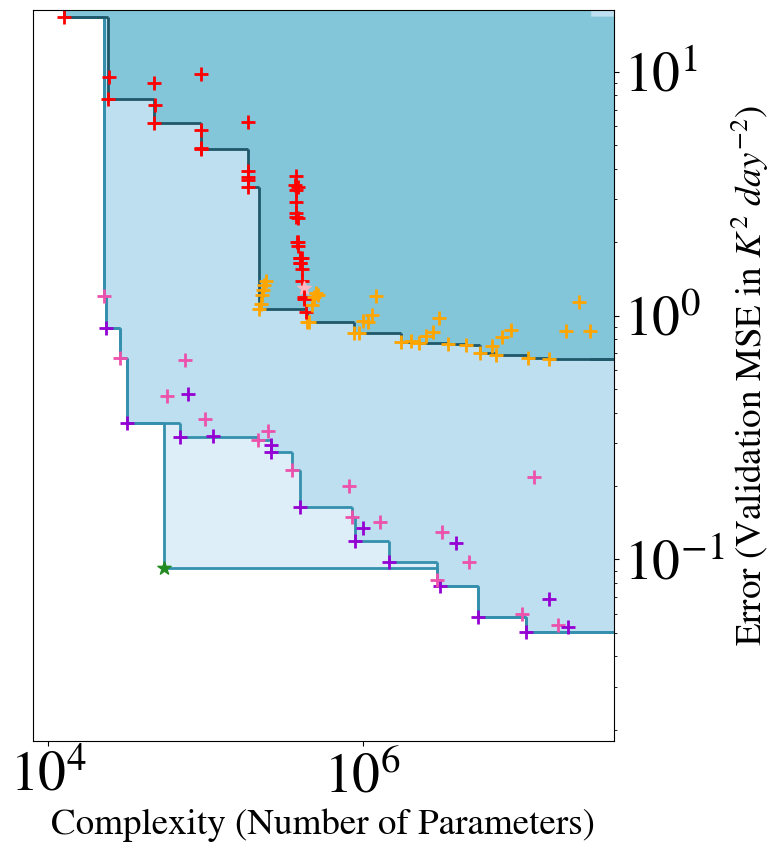

In [78]:
# Plot setup
fig, ax = plt.subplots(figsize=(7.5, 9.5))  # Combined figure and subplot creation

# Color the area above the Pareto front (Step 3)
for i in range(len(pareto_parameters3) - 1):
    ax.fill_betweenx([pareto_mse_scores3[i], max(mse_scores3)], 
                     pareto_parameters3[i], pareto_parameters3[i + 1], 
                     color=colors_fig1['pale_blue'])
# Fill the rightmost area
ax.fill_betweenx([min(mse_scores3), max(mse_scores3)], pareto_parameters3[-1], max(parameters3), 
                 color=colors_fig1['pale_blue'])
# Fill the leftmost area
ax.fill_betweenx([pareto_mse_scores3[0], max(mse_scores3)], min(parameters3), max(parameters3), 
                 color=colors_fig1['pale_blue'])

# Draw the Pareto front with vertical and horizontal lines (Step 3)
for i in range(len(pareto_parameters3)):
    if i > 0:
        ax.vlines(x=pareto_parameters3[i], ymin=pareto_mse_scores3[i-1], 
                  ymax=pareto_mse_scores3[i], color=colors_fig1['deep_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores3[i], xmin=pareto_parameters3[i], 
              xmax=pareto_parameters3[i+1] if i+1 < len(pareto_parameters3) else max(parameters3), 
              color=colors_fig1['deep_blue'], linewidth=2)

# Color the area above the Pareto front (Step 2)
for i in range(len(pareto_parameters2) - 1):
    ax.fill_betweenx([pareto_mse_scores2[i], max(mse_scores2)], 
                     pareto_parameters2[i], pareto_parameters2[i + 1], 
                     color=colors_fig1['light_blue'])
# Fill the rightmost area
ax.fill_betweenx([min(mse_scores2), max(mse_scores2)], pareto_parameters2[-1], max(parameters2), 
                 color=colors_fig1['light_blue'])
# Fill the leftmost area
ax.fill_betweenx([pareto_mse_scores2[0], max(mse_scores2)], min(parameters2), max(parameters2), 
                 color=colors_fig1['light_blue'])

# Draw the Pareto front with vertical and horizontal lines (Step 2)
for i in range(len(pareto_parameters2)):
    if i > 0:
        ax.vlines(x=pareto_parameters2[i], ymin=pareto_mse_scores2[i-1], 
                  ymax=pareto_mse_scores2[i], color=colors_fig1['deep_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores2[i], xmin=pareto_parameters2[i], 
              xmax=pareto_parameters2[i+1] if i+1 < len(pareto_parameters2) else max(parameters2), 
              color=colors_fig1['deep_blue'], linewidth=2)

# Color the area above the Pareto front
for i in range(len(pareto_parameters) - 1):
    ax.fill_betweenx([pareto_mse_scores[i], max(mse_scores)], 
                     pareto_parameters[i], pareto_parameters[i + 1], 
                     color=colors_fig1['medium_blue'])
# Fill the rightmost area
ax.fill_betweenx([min(mse_scores), max(mse_scores)], pareto_parameters[-1], max(parameters), 
                 color=colors_fig1['medium_blue'])
# Fill the leftmost area
ax.fill_betweenx([pareto_mse_scores[0], max(mse_scores)], min(parameters), max(parameters), 
                 color=colors_fig1['medium_blue'])

# Draw the Pareto front with vertical and horizontal lines
for i in range(len(pareto_parameters)):
    if i > 0:
        ax.vlines(x=pareto_parameters[i], ymin=pareto_mse_scores[i-1], 
                  ymax=pareto_mse_scores[i], color=colors_fig1['dark_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores[i], xmin=pareto_parameters[i], 
              xmax=pareto_parameters[i+1] if i+1 < len(pareto_parameters) else max(parameters), 
              color=colors_fig1['dark_blue'], linewidth=2)

# Plot all points except NNs/equations
for k in filtered_keys3:
    skip = False
    if 'linear' in k:
        col, m, cap = 'lightpink', '*', ''
    elif 'cnn' in k or 'sq_bfgs_regimes' in k:
        col, m, cap = 'red', '+', ''
    elif 'dense' in k:
        col, m, cap = 'orange', '+', ''
    elif 'u_net_plusplus' in k:
        col, m, cap = pink_cmap(5), '+', ''
    elif 'u_net' in k:
        col, m, cap = pink_cmap(1), '+', ''
    elif 'peter' in k:
        col, m, cap = 'forestgreen', '*', 'Bi-Directional RNN'
    else:
        print('k=', k)
        col, m, cap, skip = 'gray', '+', '', True

    if not skip:
        ax.scatter(np.log10(data_dict[' num_trainable_params'][k]),
                   data_dict[regime][k],
                   s=siz, color=col, zorder=2, marker=m, label=cap)

# Set limits
ax.set_xlim((3.9, 7.6))
ax.set_ylim((0.018, 18))
# Make y-axis log scale
ax.set_yscale('log')

# Improve the plot
plt.xlabel('Complexity (Number of Parameters)', fontsize=2*fz/3)
plt.ylabel('Error (Validation MSE in $K^2\ day^{-2}$)', fontsize=2*fz/3)

# Adjust legend and y-axis position based on key_y0
if regime == ' complex_heating_rate_mse_k2_day02':
    # Move y label to the right-hand side of the plot
    ax.yaxis.set_label_position("right")
    # Move the y tick labels to the right-hand side of the plot
    ax.yaxis.tick_right()
else:
    plt.legend(fontsize=fz/2, loc='upper right')

# Use scientific notation for x-ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'$10^{{{int(x)}}}$'))

plt.show()

# Tropical Precipitation Modeling

## Step 1

In [79]:
parameters, mse_scores, pareto_parameters, pareto_mse_scores, filtered_keys = \
    extract_pareto_data(tp, key_substrings=['dense'],
                    original_dict=tp['MSE'].keys(),
                    new_point_1_mse_scores=0.7, new_point_2_parameters=6.5,
                    key_x = 'complexity', key_y = 'MSE')

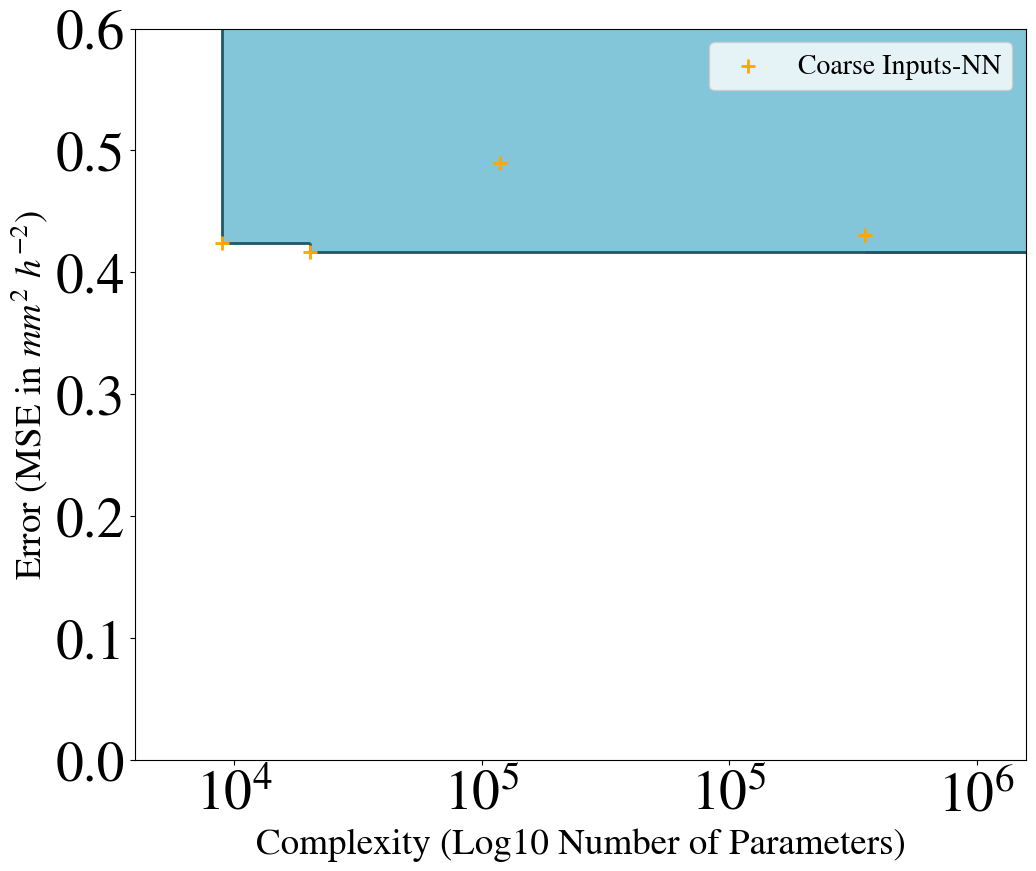

In [80]:
# Plot setup
fig,ax = plt.subplots(figsize=(23/2, 19/2))

# Color the area above the Pareto front without introducing vertical lines
for i in range(len(pareto_parameters) - 1):
    ax.fill_betweenx([pareto_mse_scores[i], 0.7],
                     pareto_parameters[i], pareto_parameters[i + 1],
                     color=colors_fig1['medium_blue'])
# Fill the rightmost and leftmost areas
ax.fill_betweenx([min(mse_scores), 0.7], pareto_parameters[-1], max(parameters),
                 color=colors_fig1['medium_blue'])
ax.fill_betweenx([pareto_mse_scores[0], 0.7], min(parameters), pareto_parameters[0],
                 color=colors_fig1['medium_blue'])

# Draw the Pareto front with vertical and horizontal lines
for i in range(len(pareto_parameters)):
    if i > 0:
        ax.vlines(x=pareto_parameters[i], ymin=pareto_mse_scores[i-1], ymax=pareto_mse_scores[i],
                  color=colors_fig1['dark_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores[i], xmin=pareto_parameters[i],
              xmax=pareto_parameters[i+1] if i+1 < len(pareto_parameters) else max(parameters),
              color=colors_fig1['dark_blue'], linewidth=2)

# Plot all points except NNs/equations
for k in tp['MSE'].keys():
    skip = False
    if 'dense' in k:
        col, m, cap = 'orange', '+', 'Coarse Inputs-NN'
    elif 'org' in k:
        col, m, cap, skip = pink_cmap(5), '+', 'High-Res Inputs-NN', True
    elif 'temporal' in k:
        col, m, cap, skip = green_cmap(2), '+', 'Simple Memory-NN', True
    else:
        print('k=', k)
        col, m, cap = 'gray', '+', ''

    if not skip:
        ax.scatter(np.log10(tp['complexity'][k]),
                   tp['MSE'][k],
                   s=siz, color=col, zorder=2, marker=m, label=cap)

# Set limits
ax.set_xlim((4.3, 6.1))
ax.set_ylim((0, 0.6))

# Improve the plot
plt.xlabel('Complexity (Log10 Number of Parameters)', fontsize=2*fz/3)
plt.ylabel('Error (MSE in $mm^2\ h^{-2}$)', fontsize=2*fz/3)

# For the legend, only keep unique entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=fz/2, loc='upper right')

# Use scientific notation for x-ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'$10^{{{int(x)}}}$'))

plt.show()

## Step 2

In [81]:
parameters2, mse_scores2, pareto_parameters2, pareto_mse_scores2, filtered_keys2 = \
    extract_pareto_data(tp, key_substrings=['dense','org'],
                    original_dict=tp['MSE'].keys(),
                    new_point_1_mse_scores=0.7, new_point_2_parameters=6.5,
                    key_x = 'complexity', key_y = 'MSE')

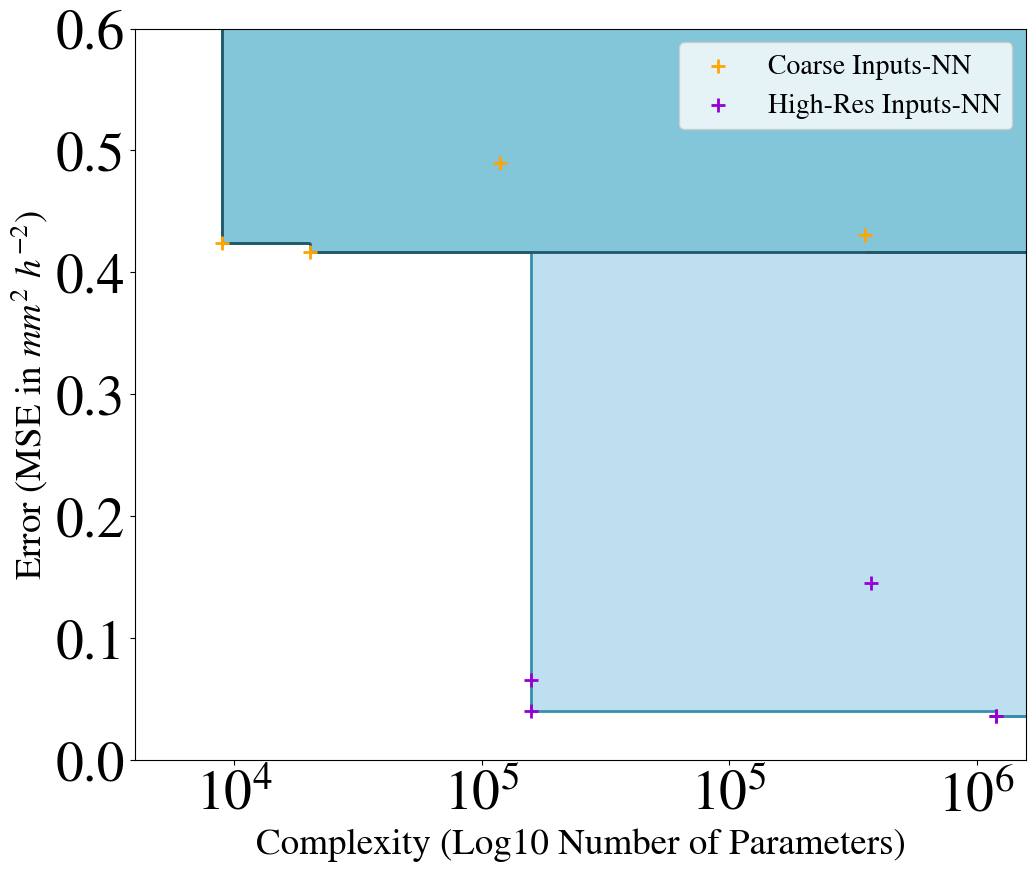

In [82]:
# Plot setup
fig, ax = plt.subplots(figsize=(11.5, 9.5))  # Combined figure and subplot creation

# Color the area above the Pareto front for Step 2
for i in range(len(pareto_parameters2) - 1):
    ax.fill_betweenx([pareto_mse_scores2[i], 0.7],
                     pareto_parameters2[i], pareto_parameters2[i + 1],
                     color=colors_fig1['light_blue'])
# Fill the rightmost and leftmost areas for Step 2
ax.fill_betweenx([min(mse_scores2), 0.7], pareto_parameters2[-1], max(parameters2),
                 color=colors_fig1['light_blue'])
ax.fill_betweenx([pareto_mse_scores2[0], 0.7], min(parameters2), pareto_parameters2[0],
                 color=colors_fig1['light_blue'])

# Draw the Pareto front with vertical and horizontal lines for Step 2
for i in range(len(pareto_parameters2)):
    if i > 0:
        ax.vlines(x=pareto_parameters2[i], ymin=pareto_mse_scores2[i-1], ymax=pareto_mse_scores2[i],
                  color=colors_fig1['deep_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores2[i], xmin=pareto_parameters2[i],
              xmax=pareto_parameters2[i+1] if i+1 < len(pareto_parameters2) else max(parameters2),
              color=colors_fig1['deep_blue'], linewidth=2)

# Color the area above the Pareto front for Step 1
for i in range(len(pareto_parameters) - 1):
    ax.fill_betweenx([pareto_mse_scores[i], 0.7],
                     pareto_parameters[i], pareto_parameters[i + 1],
                     color=colors_fig1['medium_blue'])
# Fill the rightmost and leftmost areas for Step 1
ax.fill_betweenx([min(mse_scores), 0.7], pareto_parameters[-1], max(parameters),
                 color=colors_fig1['medium_blue'])
ax.fill_betweenx([pareto_mse_scores[0], 0.7], min(parameters), pareto_parameters[0],
                 color=colors_fig1['medium_blue'])

# Draw the Pareto front with vertical and horizontal lines for Step 1
for i in range(len(pareto_parameters)):
    if i > 0:
        ax.vlines(x=pareto_parameters[i], ymin=pareto_mse_scores[i-1], ymax=pareto_mse_scores[i],
                  color=colors_fig1['dark_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores[i], xmin=pareto_parameters[i],
              xmax=pareto_parameters[i+1] if i+1 < len(pareto_parameters) else max(parameters),
              color=colors_fig1['dark_blue'], linewidth=2)

# Plot all points except NNs/equations
for k in tp['MSE'].keys():
    skip = False
    if 'dense' in k:
        col, m, cap = 'orange', '+', 'Coarse Inputs-NN'
    elif 'org' in k:
        col, m, cap, skip = pink_cmap(5), '+', 'High-Res Inputs-NN', False
    elif 'temporal' in k:
        col, m, cap, skip = green_cmap(2), '+', 'Simple Memory-NN', True
    else:
        print('k=', k)
        col, m, cap = 'gray', '+', ''

    if not skip:
        ax.scatter(np.log10(tp['complexity'][k]),
                   tp['MSE'][k],
                   s=siz, color=col, zorder=2, marker=m, label=cap)

# Set limits
ax.set_xlim((4.3, 6.1))
ax.set_ylim((0, 0.6))

# Improve the plot
plt.xlabel('Complexity (Log10 Number of Parameters)', fontsize=2*fz/3)
plt.ylabel('Error (MSE in $mm^2\ h^{-2}$)', fontsize=2*fz/3)

# Eliminate redundant legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=fz/2, loc='upper right')

# Use scientific notation for x-ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'$10^{{{int(x)}}}$'))

plt.show()

## Step 3

In [83]:
parameters3, mse_scores3, pareto_parameters3, pareto_mse_scores3, filtered_keys3 = \
    extract_pareto_data(tp, key_substrings=['dense','org','temporal'],
                    original_dict=tp['MSE'].keys(),
                    new_point_1_mse_scores=0.7, new_point_2_parameters=6.5,
                    key_x = 'complexity', key_y = 'MSE')

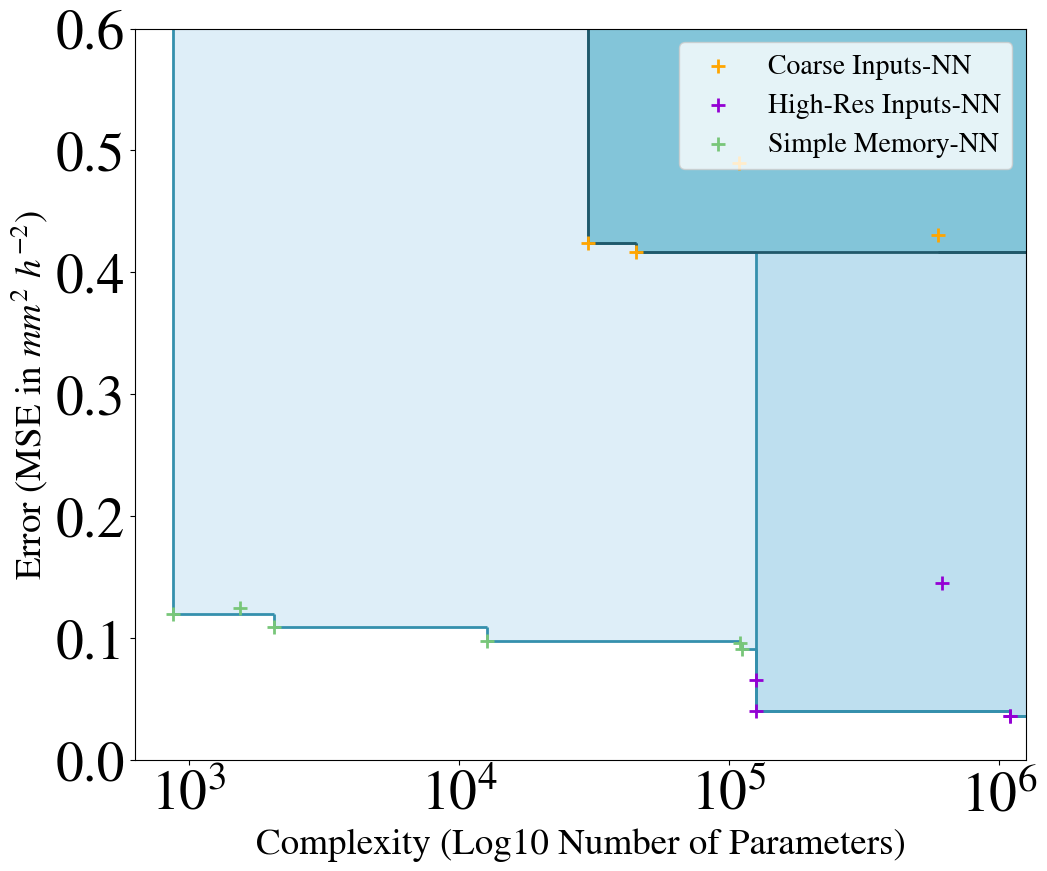

In [84]:
# Plot setup
fig, ax = plt.subplots(figsize=(11.5, 9.5))  # Combined figure and subplot creation

# Color the area above the Pareto front (Step 3)
for i in range(len(pareto_parameters3) - 1):
    ax.fill_betweenx([pareto_mse_scores3[i], max(mse_scores3)],
                     pareto_parameters3[i], pareto_parameters3[i + 1],
                     color=colors_fig1['pale_blue'])
# Fill the rightmost area
ax.fill_betweenx([min(mse_scores3), max(mse_scores3)], pareto_parameters3[-1], max(parameters3),
                 color=colors_fig1['pale_blue'])
# Fill the leftmost area
ax.fill_betweenx([pareto_mse_scores3[0], max(mse_scores3)], min(parameters3), max(parameters3),
                 color=colors_fig1['pale_blue'])

# Draw the Pareto front with vertical and horizontal lines (Step 3)
for i in range(len(pareto_parameters3)):
    if i > 0:
        ax.vlines(x=pareto_parameters3[i], ymin=pareto_mse_scores3[i-1],
                  ymax=pareto_mse_scores3[i], color=colors_fig1['deep_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores3[i], xmin=pareto_parameters3[i],
              xmax=pareto_parameters3[i+1] if i+1 < len(pareto_parameters3) else max(parameters3),
              color=colors_fig1['deep_blue'], linewidth=2)

# Color the area above the Pareto front (Step 2)
for i in range(len(pareto_parameters2) - 1):
    ax.fill_betweenx([pareto_mse_scores2[i], 0.7],
                     pareto_parameters2[i], pareto_parameters2[i + 1],
                     color=colors_fig1['light_blue'])
# Fill the rightmost area
ax.fill_betweenx([min(mse_scores2), 0.7], pareto_parameters2[-1], max(parameters2),
                 color=colors_fig1['light_blue'])
# Fill the leftmost area
ax.fill_betweenx([pareto_mse_scores2[0], 0.7], min(parameters2), max(parameters2),
                 color=colors_fig1['light_blue'])

# Draw the Pareto front with vertical and horizontal lines (Step 2)
for i in range(len(pareto_parameters2)):
    if i > 0:
        ax.vlines(x=pareto_parameters2[i], ymin=pareto_mse_scores2[i-1],
                  ymax=pareto_mse_scores2[i], color=colors_fig1['deep_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores2[i], xmin=pareto_parameters2[i],
              xmax=pareto_parameters2[i+1] if i+1 < len(pareto_parameters2) else max(parameters2),
              color=colors_fig1['deep_blue'], linewidth=2)

# Color the area above the Pareto front without introducing vertical lines
for i in range(len(pareto_parameters) - 1):
    ax.fill_betweenx([pareto_mse_scores[i], 0.7],
                     pareto_parameters[i], pareto_parameters[i + 1],
                     color=colors_fig1['medium_blue'])
# Fill the rightmost area
ax.fill_betweenx([min(mse_scores), 0.7], pareto_parameters[-1], max(parameters),
                 color=colors_fig1['medium_blue'])
# Fill the leftmost area
ax.fill_betweenx([pareto_mse_scores[0], 0.7], min(parameters), max(parameters),
                 color=colors_fig1['medium_blue'])

# Draw the Pareto front with vertical and horizontal lines
for i in range(len(pareto_parameters)):
    if i > 0:
        ax.vlines(x=pareto_parameters[i], ymin=pareto_mse_scores[i-1],
                  ymax=pareto_mse_scores[i], color=colors_fig1['dark_blue'], linewidth=2)
    ax.hlines(y=pareto_mse_scores[i], xmin=pareto_parameters[i],
              xmax=pareto_parameters[i+1] if i+1 < len(pareto_parameters) else max(parameters),
              color=colors_fig1['dark_blue'], linewidth=2)

# Plot all points except NNs/equations
for k in tp['MSE'].keys():
    skip = False
    if 'dense' in k:
        col, m, cap = 'orange', '+', 'Coarse Inputs-NN'
    elif 'org' in k:
        col, m, cap, skip = pink_cmap(5), '+', 'High-Res Inputs-NN', False
    elif 'temporal' in k:
        col, m, cap, skip = green_cmap(2), '+', 'Simple Memory-NN', False
    else:
        print('k=', k)
        col, m, cap = 'gray', '+', ''

    if not skip:
        ax.scatter(np.log10(tp['complexity'][k]),
                   tp['MSE'][k],
                   s=siz, color=col, zorder=2, marker=m, label=cap)

# Set limits
ax.set_xlim((2.8, 6.1))
ax.set_ylim((0, 0.6))

# Improve the plot
plt.xlabel('Complexity (Log10 Number of Parameters)', fontsize=2*fz/3)
plt.ylabel('Error (MSE in $mm^2\ h^{-2}$)', fontsize=2*fz/3)

# Eliminate redundant legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=fz/2, loc='upper right')

# Use scientific notation for x-ticks
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'$10^{{{int(x)}}}$'))

plt.show()